In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

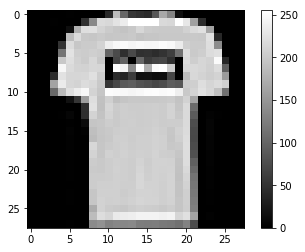

In [4]:
plt.imshow(train_images[1], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

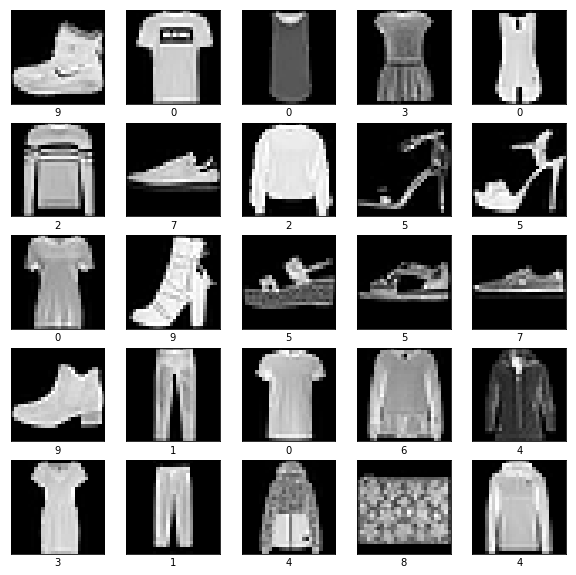

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

# INDICE: 
(con hipervinculo)

<ol>
    <li><a href="#ref1">Preparacion de la data</a></li>
    <li><a href="#ref2">Creacion del grafo</a></li>
    <li><a href="#ref3">Entrenamiento</a></li>
    <li><a href="#ref4">Funcion de pruebas</a></li>
</ol>  

<a id="ref1"></a>

# Preparacion de la data.

### Calculando el reshape de la data para que las Features sean un vector:

In [55]:
#Aplicacion de Reshape para luego filtrar la data.
xNumTrain  =  train_images.shape[0]
xNumTest   =  test_images.shape[0]
xImageSize =  train_images.shape[1]
yImageSize =  train_images.shape[2]

#Data con reshape:
trainReshapeX = np.reshape(train_images,(xNumTrain,xImageSize*yImageSize))
testReshapeX = np.reshape(test_images,(xNumTest,xImageSize*yImageSize))

### Filtrando la data para obtener unicamente los valores deseados:

In [56]:
#Creacion del diccionario:
dictLabels = {1:'Trouser', 3:'Dress', 9:'Ankle boot'}

Creacion del vector booleano para aplicar el filtro tanto al dataset de train como test:

In [9]:
getBoolFilterTrain = np.reshape(np.isin(train_labels,list(dictLabels.keys())),
                           (xNumTrain,1)) 

getBoolFilterTest = np.reshape(np.isin(test_labels,list(dictLabels.keys())),
                           (xNumTest,1)) 

Aplicacion del filtro a las etiquetas:

In [10]:
#Etiquetas del Train
yTrain = np.multiply(np.reshape(train_labels,(xNumTrain,1)),
                     getBoolFilterTrain)
yTrain = yTrain[~(yTrain==0).all(1)]

#Etiquetas del Test
yTest = np.multiply(np.reshape(test_labels,(xNumTest,1)),
                     getBoolFilterTest)
yTest = yTest[~(yTest==0).all(1)]



Aplicacion del filtro a las Features:

In [11]:
#Filtrando las features de las etiquetas anteriormente seleccionadas:
xTrain = np.multiply(getBoolFilterTrain,trainReshapeX)
xTrain = xTrain[~(xTrain==0).all(1)]

#Filtrando las features de las etiquetas anteriormente seleccionadas:
xTest = np.multiply(getBoolFilterTest,testReshapeX)
xTest = xTest[~(xTest==0).all(1)]

One-hot encoding

In [12]:
#OneHotEncoding - Y Training
oneHot_yTrain = np.reshape(np.eye(np.max(yTrain)+1)[yTrain.T],
                          (len(yTrain),np.max(yTrain)+1))[:,list(dictLabels.keys())]

#OneHotEncoding - Y Training
oneHot_yTest = np.reshape(np.eye(np.max(yTest)+1)[yTest.T],
                          (len(yTest),np.max(yTest)+1))[:,list(dictLabels.keys())]

**Separacion de la data escalada y no escalada**

In [15]:
#Data no escalada:
xTrain
xTest

#Data escalada:
scaXTrain = np.divide(xTrain,255)
scaXTest  = np.divide(xTest,255)

<a id="ref2"></a>
# Creacion del grafo:

Parametros externos utiles al grafo:

In [16]:
#Parametros a utilizar, externos:
miniBatch = 32
numLabels = len(dictLabels)
numFeatures = xImageSize*yImageSize

Creacion del grafo:

In [85]:
#Nombramiento del grafo:
logicRegresion = tf.Graph()

#construccion:
with logicRegresion.as_default():
    #Creacion de la primera agrupacion: Se incluira aqui variables, placeholders, etc.
    with tf.name_scope("DataToUse") as scope:   
        
        #Learning rate as placeholder
        learningRate = tf.placeholder(dtype=tf.float32,name='LearningRate')
        
        #Features, en este caso seran matrices de (32x784)
        preX = tf.placeholder(dtype=tf.float32,shape=[miniBatch,numFeatures],
                              name="preFeaturesVect") #vector de 32x784
        
        #X final ya con la matriz de unos
        X = tf.pad(tensor=preX,paddings= tf.constant([[0,0],[1,0]]), 
                   mode='CONSTANT',constant_values=1.0000) #vector de 32x785
        
        #Creacion de las etiquetas:
        Y = tf.placeholder(dtype=tf.float32,shape=[miniBatch,numLabels],
                              name="ClothesType") #Vector de 32x3
        
        
        #Creacion de la matriz de parametros a entrenar, debido a que el bias va incluido, se agrega una  
        #caracteristica mas.
        weights = tf.Variable(tf.random_normal([numFeatures+1,numLabels],
                                               mean=0,
                                               stddev=0.01,
                                               name="Weights")) #Matriz de 785x3
        
        varInit = tf.global_variables_initializer()
    
    with tf.name_scope("Hipothesis") as scope:
        #Matriz de 32x3, distribucion de probabilidad ya que se utiliza softmax como distribucion de activacion
        Hypothesis = tf.nn.softmax(tf.matmul(X,weights),axis=1,name="Hipothesis")
    
    
    with tf.name_scope("CostFunction") as scope:
        #Defining our cost function - Squared Mean Error
        ySoftMax = tf.nn.softmax(Y,axis=1,name="SoftMaxY")
        crossEntropyLoss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = ySoftMax, 
                                                                      logits = tf.matmul(X,weights),
                                                                      name = "FuncionCosto")
        #Error a reducir
        finalCrossEntropy = tf.reduce_mean(crossEntropyLoss,axis=0,name="MeasureError")
        
    with tf.name_scope("OptimizationMethod") as scope:
        #Aplicacion del gradient descent como funcion de optimizacion
        gradientDescent = tf.train.GradientDescentOptimizer(learningRate).minimize(finalCrossEntropy)
    
    with tf.name_scope("TrainingVisualization") as scope:
        predicttionBool = tf.equal(tf.argmax(Hypothesis,1),tf.argmax(Y,1)) # me retorna un vector bool de 1xN
        accuracyCalc = tf.reduce_mean(tf.cast(predicttionBool, "float"))

<a id="ref3"></a>
# Entrenamiento

In [86]:
def trainingModel(features, labels, miniBatch, lr, epochs):
    batch = int(labels.shape[0]/miniBatch)
    tf.reset_default_graph()
    with tf.Session(graph=logicRegresion) as session:
        writer = tf.summary.FileWriter('./graphs/Training',session.graph)
        session.run(varInit)
        #for aplicando Epochs
        for j in range(epochs):
            #For aplicando el miniBatch:
            for i in range(batch):
                #print("Rango", (i*miniBatch,(i+1)*miniBatch))
                session.run([gradientDescent],feed_dict={learningRate:lr, preX:features[i*miniBatch:(i+1)*miniBatch], 
                                                         Y:labels[i*miniBatch:(i+1)*miniBatch]})
                error,accuracy, pesos = session.run([finalCrossEntropy,accuracyCalc, weights],
                                             feed_dict={learningRate:lr, preX:features[i*miniBatch:(i+1)*miniBatch], 
                                                        Y:labels[i*miniBatch:(i+1)*miniBatch]})
            if j%1==0:
                print('Error: ',str(error),' accuracy: ', str(accuracy))
        writer.close()
        return pesos

In [87]:
trainedW = trainingModel(features=scaXTrain,labels=oneHot_yTrain,miniBatch=32,lr=0.003,epochs=2)

Error:  0.9975884  accuracy:  0.9375
Error:  0.9950776  accuracy:  0.9375


<a id="ref4"></a>
# Creacion de la funcion para la evaluacion del algoritmos

Creacion del grafo para ejecutar la funcion de pruebas (Grafo independiente del anterior):

In [88]:
testImage = tf.Graph()
with testImage.as_default(): 
    with tf.name_scope("DataToUse") as scope:
        preTestX = tf.placeholder(dtype=tf.float32, shape=(1,xImageSize*yImageSize),name="Image")
        padding = tf.constant([[0,0],[1,0]])
        TestXt = tf.pad(tensor=preTestX,paddings=padding, mode='CONSTANT', 
                        constant_values=1.0000,name="ImageAdjusted")
    
    with tf.name_scope("testHypothesis") as scope:
        trainedValues = tf.placeholder(dtype=tf.float32,shape=(785,3),name="TrainedWeights")
        #Vector de 1x3 con la mejor probabilidad
        Y_hat = tf.nn.softmax(tf.matmul(TestXt,trainedValues),axis=1,name="ProbabilityList")

In [89]:
def testFunction(X,W):
    with tf.Session(graph=testImage) as session:
        writer = tf.summary.FileWriter('./graphs/Testing',session.graph)
        prediction = session.run(Y_hat, feed_dict={preTestX:X,trainedValues:W})
        writer.close()
    finalLabel = dictLabels[list(dictLabels.keys())[np.argmax(prediction[0])]]    
    plt.figure(figsize=(15,15))
    plt.subplot(5,5,5)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(X,(28,28)), cmap='gray')
    plt.xlabel(finalLabel)
    plt.show()

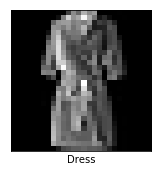

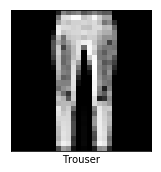

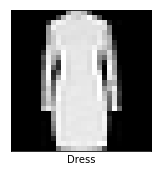

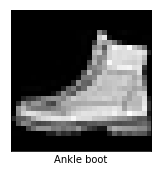

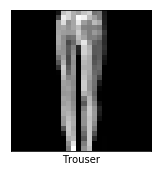

In [90]:
for i in range(5):
    testFunction(X=scaXTest[[np.random.randint(0,2999)]],W=trainedW)

# Graficas de los grafos:

### Grafo de entrenamiento:

**Grafo principal:**
<img src="trainingGraph.png">

**Sub-grafos**
<img src="trainingvisualization.png">
<img src="optimizationMethod.png">
<img src="costFunction.png">
<img src="DataToUse.png">
<img src="hypo.png">

### Grafo  para pruebas:

**Grafo principal**
<img src="testGraph.png">

**Sub-grafos**
<img src="data.png">
<img src="hypoTest.png">


# Resolucion de dudas

Nota: Se les envia el feed_dict SOLO A LOS PLACEHOLDERS. Evaluacion perezosa: Primero crear la estructura y luego ejecutarla. Modelo parametrico -> Parametros entrenables (esto es tf.Variable), esta es la pieza movil.

En ejecucion, tensor flows ejecuta todas las dependencias del grafo que se ejecuta.

My own questions:

* Para filtrar podemos usar vectores de booleanos. Conceptualmente se entrenan cuatro modelos de regresion logistica de manera paralelo. Al final en el dataSet
* Cada pixel de la imagen es una caracteristica!!!!!
* Reshape: 
* Minbatch -> sets de 32 ejemplos 
* Normalizacion <- Introduction to Feature Engineering. (Hace que el gradient descent tenga una curva mas facil de descender)



**NOTA EN EL MINIBATCH VAMOS A ENTRENAR SI O SI, SETS DE 32 INPUTS**

Si el dataset tuviera 3200 imagenes, por cada epoch